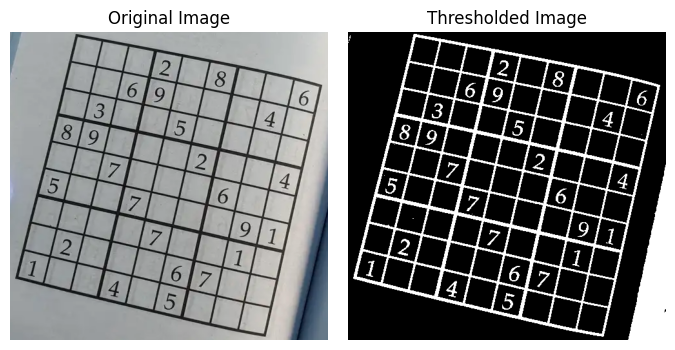

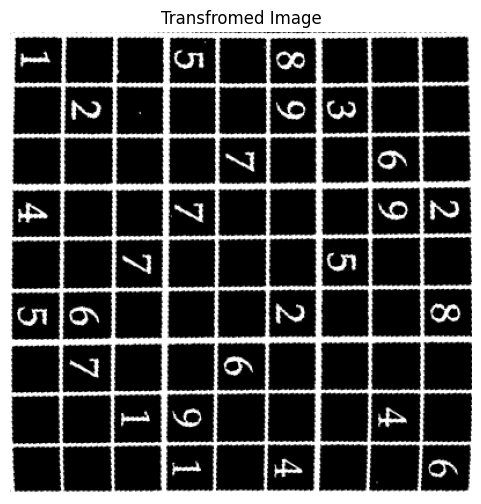

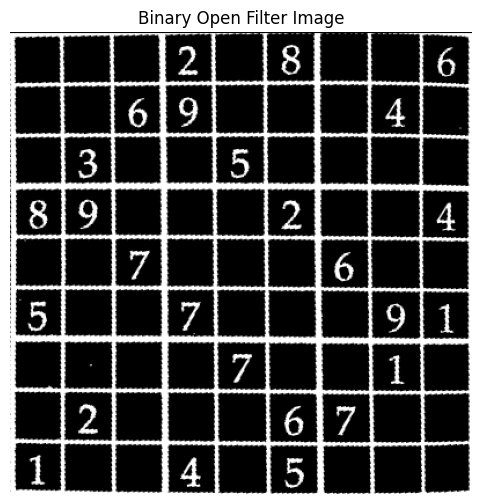

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


List of Numbers['2', '8', '6', '6', '9', '4', '3', '5', '8 | 9', '2', '4', '7', '6', '5', '7.', '9', '1', '7', '1', '2', '6', '7', '1', '4', '5']
Text array[2866943589247657, 9171267145]
Int Array (26): [2, 8, 6, 6, 9, 4, 3, 5, 8, 9, 2, 4, 7, 6, 5, 7, 9, 1, 7, 1, 2, 6, 7, 1, 4, 5]
Grid Size:44


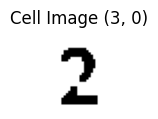

WPC[3,0]:0:180
WPC[5,0]:1:243
WPC[8,0]:2:181
WPC[2,1]:3:202
WPC[3,1]:4:203
WPC[7,1]:5:200
WPC[1,2]:6:200
WPC[4,2]:7:211


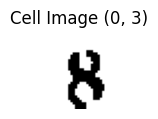

WPC[0,3]:8:224
WPC[1,3]:9:189
WPC[5,3]:10:179
WPC[8,3]:11:150
WPC[0,4]:12:64
WPC[2,4]:13:156
WPC[6,4]:14:201
WPC[0,5]:15:209
WPC[3,5]:16:171
WPC[7,5]:17:175
WPC[8,5]:18:114
WPC[4,6]:19:157
WPC[6,6]:20:62
WPC[7,6]:21:103
WPC[8,6]:22:106
WPC[1,7]:23:210
WPC[5,7]:24:184
WPC[6,7]:25:224
WPC[7,7]:26:68


IndexError: list index out of range

In [7]:
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
import easyocr

# Configure pytesseract path to the location where tesseract.exe is installed
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract.exe'  # Update the path based on your installation


def preprocess_image(image_path):
    """Load an image, convert to grayscale, and apply adaptive thresholding."""
    image = cv2.imread(image_path)
    # gray_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 

    
    ret,processed_image = cv2.threshold(gray_image,127,255,cv2.THRESH_BINARY)
    # processed_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    processed_image = cv2.bitwise_not(processed_image)
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 1, 1)
    plt.imshow(processed_image, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')

    return processed_image

def extract_sudoku_grid(image):
    """Extract Sudoku grid from the image."""
    contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    largest_contour = contours[0]
    perimeter = cv2.arcLength(largest_contour, True)
    roi = cv2.approxPolyDP(largest_contour, 0.02 * perimeter, True)
    return roi

def get_perspective_transform(image, corners):
    """Apply perspective transform to the grid."""
    corners = sorted(np.concatenate(corners).tolist())
    top_left, top_right, bottom_right, bottom_left = corners[0], corners[1], corners[-1], corners[2]
    side = max([
        np.linalg.norm(np.subtract(top_left, top_right)),
        np.linalg.norm(np.subtract(top_right, bottom_right)),
        np.linalg.norm(np.subtract(bottom_right, bottom_left)),
        np.linalg.norm(np.subtract(bottom_left, top_left))
    ])
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')
    dst = np.array([[0, 0], [side - 1, 0], [side - 1, side - 1], [0, side - 1]], dtype='float32')
    m = cv2.getPerspectiveTransform(src, dst)
    transformed_image = cv2.warpPerspective(image, m, (int(side), int(side)))
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(transformed_image, cmap='gray')
    plt.title('Transfromed Image')
    plt.axis('off')
    plt.show()
    return cv2.warpPerspective(image, m, (int(side), int(side)))

def count_white_pixels(image):
    """
    Count the number of white pixels in an image.

    Parameters:
    - image: image object.

    Returns:
    - int: Number of white pixels.
    """
   
    # Define what is considered 'white'
    # In a grayscale image, white is 255
    white_threshold = 64
    
    # Count pixels equal to the white_threshold
    white_count = np.sum(image < white_threshold)

    return white_count

def extract_digits(transformed_image, int_array):
    """Extract digits from each cell of the Sudoku grid."""
    grid_size = transformed_image.shape[0] // 9
    print("Grid Size:" + str(grid_size))
    transformed_image = cv2.bitwise_not(transformed_image)

    # digits = pytesseract.image_to_string(transformed_image, lang='eng', config='--psm 11')
    # print("sudoku grid image:")
    # print(digits.strip())  

    index = 0
    grid = []
    for y in range(9):
        row = []
        for x in range(9):
            clip = 5 # Clip 3 pixels from each side to remove grid lines
            x1 = x * grid_size
            y1 = y * grid_size
            x2 = x1 + grid_size
            y2 = y1 + grid_size

            cell = transformed_image[y1+clip:y2-clip, x1+clip:x2-clip]

            # Grayscale, Gaussian blur, Otsu's threshold
            # image = cv2.imread('1.png')
            # gray = cv2.cvtColor(cell, cv2.COLOR_BGR2GRAY)
            blur = cv2.GaussianBlur(cell, (5,5), 0)
            thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

            # Morph open to remove noise and invert image
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
            opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
            # invert = 255 - opening
            cellImg = opening
            cellImg = cv2.bitwise_not(cellImg)


            

            if x == 3 and y == 0:
                plt.figure(figsize=(1, 1))
                plt.imshow(cellImg, cmap='gray')
                plt.title('Cell Image (3, 0)')
                plt.axis('off')
                plt.show()

            if x == 0 and y == 3:
                plt.figure(figsize=(1,1))
                plt.imshow(cellImg, cmap='gray')
                plt.title('Cell Image (0, 3)')
                plt.axis('off')
                plt.show()

            # digit = pytesseract.image_to_string(cell, config='--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789')
            # digit = pytesseract.image_to_string(cell, config='--psm 11 --oem 3')
            # digit = pytesseract.image_to_string(cellImg, lang='eng', config='--psm 11')
            # celltext = digit.strip()
            # reader = easyocr.Reader(['en']) # specify the language  
            # digit = reader.readtext(cellImg)

            # for (bbox, text, prob) in digit:
            #     print(f'Text: {text}, Probability: {prob}')
            #     celltext = text

           

            # print("Value in ["+str(x)+","+str(y)+"]:" + str(celltext))
            try:
                # if int(str(celltext)) == 1 or int(str(celltext)) == 2 or int(str(celltext)) == 3 or int(str(celltext)) == 4 or int(str(celltext)) == 5 or int(str(celltext)) == 6 or int(str(celltext)) == 7 or int(str(celltext)) == 8 or int(str(celltext)) == 9:
                #     row.append(int(str(celltext)))
                count = count_white_pixels(cellImg)
                if count > 50:
                    print("WPC["+str(x)+","+str(y)+"]:" + str(index) + ":" + str(count))
                    try:
                        row.append(int(int_array[index]))
                    except:
                        print("Value in ["+str(x)+","+str(y)+"]:" + str(int_array[index]))
                    # row.append(int(int_array[index]))
                    index = index + 1
                else:
                    row.append(int(0)) 
                # row.append(int(digit.strip()))
            except ValueError as ve:
                # print(type(ve), ve)
                row.append(0)  # Assuming empty cell if OCR fails to recognize a digit
                # print("error")
        grid.append(row)
    return grid

def apply_opening_filter(image):
    # Load the image
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Threshold the image to make it binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
 
    kernel_size = 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the opening filter
    opened_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)

    # Save or display the output image
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(opened_image, cmap='gray')
    plt.title('Binary Open Filter Image')
    plt.axis('off')
    plt.show()
    # cv2.imwrite('opened_image.jpg', opened_image)
    # cv2.imshow('Original', binary_image)
    # cv2.imshow('Opened', opened_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()

def apply_close_filter(image):
    # Load the image
    # image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.bitwise_not(image)
    # Threshold the image to make it binary
    _, binary_image = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Define the kernel size for the morphological operation
    kernel_size = 1
    kernel = np.ones((kernel_size, kernel_size), np.uint8)

    # Apply the opening filter
    closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_CLOSE, kernel)
    # closed_image = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
    
    # Save or display the output image
    # Show the equalized image
    plt.figure(figsize=(6, 6))
    plt.imshow(closed_image, cmap='gray')
    plt.title('Binary Closed Filter Image')
    plt.axis('off')
    plt.show()

def rotate_image(image, angle):
    """
    Rotate the image by the given angle in degrees.

    Parameters:
    - image: Input image as a numpy array (loaded via cv2.imread or similar).
    - angle: Float. The angle to rotate the image, in degrees. Positive values rotate
             the image counterclockwise, and negative values rotate it clockwise.

    Returns:
    - Rotated image as a numpy array.
    """
    # Get the image dimensions (height, width)
    height, width = image.shape[:2]
    
    # Compute the center of the image from which to rotate
    center = (width / 2, height / 2)
    
    # Get the rotation matrix using cv2.getRotationMatrix2D
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Determine the bounding box of the new image after the rotation (to avoid clipping)
    cos_val = np.abs(rotation_matrix[0, 0])
    sin_val = np.abs(rotation_matrix[0, 1])
    
    # Compute the new dimensions of the image
    new_width = int((height * sin_val) + (width * cos_val))
    new_height = int((height * cos_val) + (width * sin_val))
    
    # Adjust the rotation matrix to account for translation
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]
    
    # Perform the actual rotation and return the image
    return cv2.warpAffine(image, rotation_matrix, (new_width, new_height))

def box_outline_text(image):
    # img = cv2.imread('image.png')
    h, w = image.shape
    boxes = pytesseract.image_to_boxes(image) 
    for b in boxes.splitlines():
        b = b.split(' ')
        image = cv2.rectangle(image, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)

    # cv2.imshow('img', img)
    plt.figure(figsize=(3, 3))
    plt.imshow(image, cmap='gray')
    plt.title('Image 2 text OCR')
    plt.axis('off')
    plt.show()

def transform_image(image, angle, flip_horizontally=False, flip_vertically=False):
    """
    Rotate and possibly flip an image.

    Parameters:
    - image: Input image as a numpy array (loaded via cv2.imread or similar).
    - angle: Float. The angle to rotate the image, in degrees. Positive values rotate
             the image counterclockwise, and negative values rotate it clockwise.
    - flip_horizontally: Boolean. If True, the image will be flipped horizontally.
    - flip_vertically: Boolean. If True, the image will be flipped vertically.

    Returns:
    - Transformed image as a numpy array.
    """
    # Get the image dimensions (height, width)
    height, width = image.shape[:2]
    
    # Compute the center of the image from which to rotate
    center = (width / 2, height / 2)
    
    # Get the rotation matrix using cv2.getRotationMatrix2D
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    
    # Determine the bounding box of the new image after the rotation (to avoid clipping)
    cos_val = np.abs(rotation_matrix[0, 0])
    sin_val = np.abs(rotation_matrix[0, 1])
    
    # Compute the new dimensions of the image
    new_width = int((height * sin_val) + (width * cos_val))
    new_height = int((height * cos_val) + (width * sin_val))
    
    # Adjust the rotation matrix to account for translation
    rotation_matrix[0, 2] += (new_width / 2) - center[0]
    rotation_matrix[1, 2] += (new_height / 2) - center[1]
    
    # Perform the actual rotation
    rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height))

    # Flip the image if required
    if flip_horizontally:
        rotated_image = cv2.flip(rotated_image, 1)  # flip horizontally
    if flip_vertically:
        rotated_image = cv2.flip(rotated_image, 0)  # flip vertically

    plt.figure(figsize=(6, 6))
    plt.imshow(rotated_image, cmap='gray')
    plt.title('Binary Open Filter Image')
    plt.axis('off')
    plt.show()

    return rotated_image

def text_to_integers(text):
    """
    Convert a string containing numbers, spaces, and '|' characters to an array of integers.

    Parameters:
    - text: str. The input text string containing numbers, spaces, and '|' characters.

    Returns:
    - list of int: An array of integers extracted from the text.
    """
    # Remove spaces and '|' characters
    cleaned_text = text.replace(' ', '').replace('|', '')
    
    # Convert the cleaned text to a list of integers
    # Assume that each number is separated by non-numeric characters
    import re
    # Extract numbers from the cleaned text
    numbers = re.findall(r'\d+', cleaned_text)
    
    # Convert list of number strings to integers
    integer_array = [int(num) for num in numbers]

    return integer_array

def list_to_string(input_list, separator=' '):
    """
    Convert a list of items into a single string, with elements separated by a specified separator.

    Parameters:
    - input_list: list. The list of items to be converted into a string.
    - separator: str (optional). The separator to use between elements in the output string. Default is a space.

    Returns:
    - str: A string with all the list elements joined by the specified separator.
    """
    # Convert all non-string elements in the list to strings
    string_list = [str(item) for item in input_list]
    
    # Join all elements of the list into a single string with the specified separator
    result_string = separator.join(string_list)

    return result_string

def string_to_char_array(input_string):
    """
    Convert a string into an array of characters.

    Parameters:
    - input_string: str. The string to be converted into an array of characters.

    Returns:
    - list: A list containing each character of the string as an element.
    """
    # Convert the string into a list of characters
    char_array = list(input_string)

    return char_array

def string_to_digit_array(input_string):
    """
    Convert a string of digits into an array of 1-digit integers.
    
    Parameters:
    - input_string: str. The input string containing numerical characters.
    
    Returns:
    - list of int: An array containing 1-digit integers extracted from the string.
    """
    # Create an array of integers, converting each digit in the string to an integer
    digit_array = [int(char) for char in input_string if char.isdigit()]

    return digit_array

def main(image_path):
    processed_image = preprocess_image(image_path)
    roi = extract_sudoku_grid(processed_image)
    transformed_image = get_perspective_transform(processed_image, roi)
    
    # Perform text extraction
    # data = pytesseract.image_to_string(invert, lang='eng', config='--psm 6')
    # data = pytesseract.image_to_string(invert, config='--psm 6 --oem 3 -c tessedit_char_whitelist=0123456789')
   
    rotated_image = rotate_image(transformed_image, 90)
    transformed_image = transform_image(rotated_image, 0, flip_horizontally=False, flip_vertically=False)
    
    reader = easyocr.Reader(['en']) # specify the language  
    result = reader.readtext(transformed_image)

    listofnumbers = []

    for (bbox, text, prob) in result:
        # print(f'Text: {text}, Probability: {prob}')
        listofnumbers.append(text)
    
    print("List of Numbers"+str(listofnumbers))
    output_string = list_to_string(listofnumbers)   
    text_array = text_to_integers(output_string)
    print("Text array"+str(text_array))
    int_array = string_to_digit_array(output_string)
    print("Int Array (" + str(len(int_array)) +"): " + str(int_array))

    # apply_opening_filter(rotated_image)
    # apply_close_filter(rotated_image)
    # box_outline_text(rotated_image)
    sudoku_grid = extract_digits(transformed_image, int_array)
    # sudoku_grid = extract_digits(transformed_image)
    return sudoku_grid
 
# Example Usage
sudoku_grid = main(".//sudoku_test.png")
# digit = pytesseract.image_to_string(cell, config='--psm 11 --oem 3 -c tessedit_char_whitelist=0123456789')
# digit = pytesseract.image_to_string(cell, config='--psm 11 --oem 3')

print(np.array(sudoku_grid))


In [ ]:
from flask import Flask, request, jsonify
import cv2
import numpy as np
import matplotlib as plt

# Import your Sudoku solver here
def solve(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.title('Uploaded Sudoku Image')
    plt.axis('off')
    plt.show()

app = Flask(__name__)

@app.route('/solve', methods=['POST'])
def solve_sudoku():
    image_data = request.form['image']
    # Process the image data (remove the data URL prefix)
    image_data = image_data.split(',')[1]
    # Decode the base64 image data
    nparr = np.frombuffer(base64.b64decode(image_data), np.uint8)
    # Read the image using OpenCV
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Perform necessary image processing and solve the Sudoku puzzle
    # using your Sudoku solver
    solution = solve(image)
    
    return jsonify(solution)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [07/May/2024 04:37:03] "POST / HTTP/1.1" 404 -


In [ ]:
from flask import Flask, request, jsonify
import cv2
import numpy as np

# Import your Sudoku solver here
def solve(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image, cmap='gray')
    plt.title('Uploaded Sudoku Image')
    plt.axis('off')
    plt.show()

app = Flask(__name__)

@app.route('/solve', methods=['POST'])
def solve_sudoku():
    image_data = request.form['image']
    # Process the image data (remove the data URL prefix)
    image_data = image_data.split(',')[1]
    # Decode the base64 image data
    nparr = np.frombuffer(base64.b64decode(image_data), np.uint8)
    # Read the image using OpenCV
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Perform necessary image processing and solve the Sudoku puzzle
    # using your Sudoku solver
    solution = solve(image)
    
    return jsonify(solution)

if __name__ == '__main__':
    app.run(host='localhost', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit
[2024-05-07 04:44:23,838] ERROR in app: Exception on /solve [POST]
Traceback (most recent call last):
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1484, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1469, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
           ^^^^^^^^^^^^^^^^^^^^^^^

In [8]:
from flask import Flask, request, jsonify
from flask_cors import CORS
import cv2
import numpy as np
import base64  # Import the base64 module
# Import your Sudoku solver here

app = Flask(__name__)
CORS(app)  # Enable CORS for all routes and origins

@app.route('/solve', methods=['POST'])
def solve_sudoku():
    image_data = request.form['image']
    # Process the image data (remove the data URL prefix)
    image_data = image_data.split(',')[1]
    # Decode the base64 image data
    nparr = np.frombuffer(base64.b64decode(image_data), np.uint8)
    # Read the image using OpenCV
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Perform necessary image processing and solve the Sudoku puzzle
    # using your Sudoku solver
    solution = solve(image)
    
    return jsonify(solution)

if __name__ == '__main__':
    app.run(host='localhost', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://localhost:5000
Press CTRL+C to quit
[2024-05-07 04:47:22,633] ERROR in app: Exception on /solve [POST]
Traceback (most recent call last):
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 2190, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1486, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ikem Nkurumeh\AppData\Local\Programs\Python\Python311\Lib\site-packages\flask_cors\extension.py", line 178, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
                                                ^^^^^^^^^^^^^^^^^^
  File "C:\Users\Ikem Nkurumeh\AppData\Roaming\Python\Python311\site-packages\flask\app.py", line 1484, in full_dispatch_request
    rv = self.dispat